In [23]:
pip install -r install.txt

     |████████████████████████████████| 153kB 242kB/s eta 0:00:01    |████▎                           | 20kB 262kB/s eta 0:00:01
     |████████████████████████████████| 81kB 4.5MB/s eta 0:00:011
  Stored in directory: /Users/yuanwenliang/Library/Caches/pip/wheels/a9/ef/7c/7bbf228825e8717adaa84cd4b6c4ed8649b7958dd2bac45076
Successfully built geojsonio
Note: you may need to restart the kernel to use updated packages.


## Creating Area of Interest (AOI)

**Important: the way load() in Image moudlue is weriod. It doesn't follow the convention that in (i,j), i reprensents row and j reprensents column. It's other way round.**

In [252]:
from PIL import Image, ImageDraw
test = Image.new("RGBA", (2, 2))
test.putdata([(0,0,0,0),(255,255,255,255),(0,0,0,255),(123,123,123,255)])

for i in range(2):
    for j in range(2):
        print(i,j)
        print(test.load()[i,j])

#test.show()

0 0
(0, 0, 0, 0)
0 1
(0, 0, 0, 255)
1 0
(255, 255, 255, 255)
1 1
(123, 123, 123, 255)


In [274]:
from PIL import Image, ImageDraw
import glob
import os
import numpy as np

# The initial release contains only one tile, so lets hardcode its location
# here.  When you have more tiles, you can update this
TILE_X = 7680
TILE_Y = 10240

# The expected value of a Pixel in a mask file indicating that the pixel is
# within that region.  Tuple value, (Red, Green, Blue, Alpha)
IS_IN_MASK_PIXEL_VALUE = (0, 0, 0, 255)

# Tile width / height in pixels

TILE_WIDTH_PX = 512
TILE_HEIGHT_PX = 512

# Get the physical path to the PNG image containing the mask file
def get_mask_path(tile_x, tile_y, mask_type): #mask_type is sugarcane-region coz it's in the file name
    path = f"./data/sentinel-2a-tile-{tile_x}x-{tile_y}y/masks/{mask_type}-mask.png"
    return path


# Get a list of all the image tiles for a specific x,y coordinate
# for the specified band
def get_timeseries_image_paths(tile_x, tile_y, band, date):
    path = f"./data/sentinel-2a-tile-{tile_x}x-{tile_y}y/timeseries/{tile_x}-{tile_y}-{band}-{date}.png"
    #path = glob.glob(path)
    #path = path[0] # get the first date 
    return path 


# Open an image file and get all the pixels, be careful of the x,y swaps
def get_image_pixels(path):
    img = Image.open(path)
    pixels = img.load() 
    return pixels

def pixels_swap(pixels,pixel_x,pixel_y):
    pixels[pixel_x,pixel_y] = pixels[pixel_y,pixel_x]
    return pixels
    
def is_in_mask(mask_pixels, pixel_x, pixel_y):
    if mask_pixels[pixel_x,pixel_y] == IS_IN_MASK_PIXEL_VALUE: # the pixel in the mask file is black 
        return True 
    else:
        return False

    
def get_cropped_pixels(tile_x, tile_y, mask_type, band, date):
    
    # get the pixels from mask and image 
    mask_pixels = get_image_pixels(get_mask_path(tile_x, tile_y, mask_type))
    image_pixels = get_image_pixels(get_timeseries_image_paths(tile_x, tile_y, band, date))
    
    
    width = TILE_WIDTH_PX 
    height = TILE_HEIGHT_PX 

    for x in range(0, width):
        for y in range(0, height):

            # is the pixel in my mask?
            in_mask = is_in_mask(mask_pixels, x, y)
            if in_mask:
                pass
            else:
                image_pixels[x,y] = (0,0,0,0) #if not in mask, change to transparent
    
    cropped_pixels = image_pixels
    return cropped_pixels
    

def sequence_cropped_pixels(tile_x, tile_y, mask_type, band, date):
    
    # get the pixels from cropped
    cropped_pixels = get_cropped_pixels(tile_x, tile_y, mask_type, band, date)

    cropped_sequence = []
    
    width = TILE_WIDTH_PX 
    height = TILE_HEIGHT_PX 
    for i in range(0, width):
        for j in range(0, height):
            cropped_sequence.append(cropped_pixels[j,i]) 
            # flipping the image coz of the way load() reads pixels
    return cropped_sequence


# print_ascii_mask doesn't really do anything useful other than showing some masks
def print_ascii_mask(tile_x, tile_y, mask_type):
    mask_pixels = get_image_pixels(get_mask_path(tile_x, tile_y, mask_type))

    # We don't really want to display ASCII art that is 512 characters long as it will be
    # too long to show in a terminal, so lets scale it
    scale_factor = 10

    width_in_chars = int(TILE_WIDTH_PX / scale_factor)
    height_in_chars = int(TILE_HEIGHT_PX / scale_factor)

    for y_char in range(0, width_in_chars):
        for x_char in range(0, height_in_chars):
            # Convert the character index back to actual pixels
            pixel_x = x_char * scale_factor
            pixel_y = y_char * scale_factor

            # is the pixel in my mask?
            in_mask = is_in_mask(mask_pixels, pixel_x, pixel_y)
            if in_mask:
                print("X", end="")
            else:
                print(" ", end="")

        # Print a newline at the end of each row
        print("\n", end="")


                                                   
XXXXXXXXXXXXXXXXXXXXXX                      XXX    
XXXXXXXXXXXXXXXXXXXXXX                      XXX    
XXXXXXXXXXXXXXXXXXXXX      X                XXXX   
 XXXXXXXXXXXXXXXXXXXXXX    XX               XX     
XXXXXXXXXXXXXXXXXXXXXXXX  XXXX               XXX   
XXXXXXXXXXXXXXXXXXXXXXXXX XXXXX             XXX    
XXXXXXXXXXXXXXXXXXXXXXXXX XXX  X             XX   X
X XXXX  XXXXXXXXXXXXXXXXXXXXX    X               XX
XX  XX     XXXXXXXX XXXXXXXXXXX XXXXXXX           X
XXX  XXXX  XXXXX XX   XXXXXXXXXXXXXXXXX            
 X XX XXXXXXXXX       XXXXXXXXXXXXXX               
XXXXX  XXXXXXXXX      XXXXXXXXXXXXXX       XXXX    
  XXXXXXXXXXXXXX      XXXXXXXXXXXXXX        XXX    
    XXXXXXXXXXXXXXXXX XXXXXXXXXXXXXX   XX          
XXXX     XXXXXXXXXXXXXXXXXXXXXXXXXXXXX XXX         
XXXXXXX     XXXXXXXXXXXXXXXXXXXXXXXXXXX XXX        
XXXXXXXX    XXXXXXXXXXXXXXXXXXXXXXXXXXXXX XXX      
XXXXXXXX   XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX     
XXXXXXXXX  X

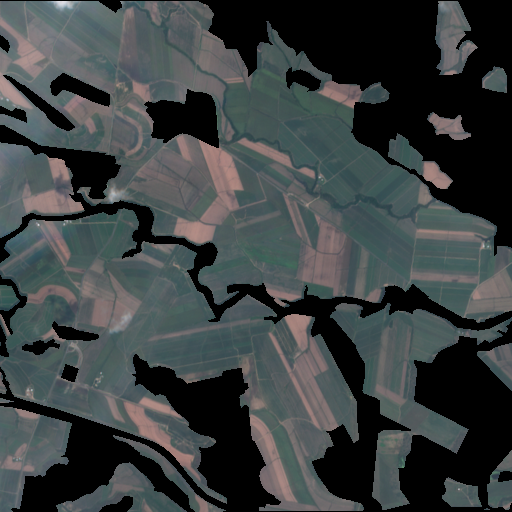

In [276]:
full = Image.open(get_timeseries_image_paths(TILE_X, TILE_Y, 'TCI','2016-12-22'))
mask = Image.open(get_mask_path(TILE_X, TILE_Y, mask_type="sugarcane-region"))
full.show()
#mask.show()
print(print_ascii_mask(TILE_X, TILE_Y, mask_type="sugarcane-region"))
cropped = Image.new("RGBA", (512, 512))
cropped.putdata(sequence_cropped_pixels(
    TILE_X, TILE_Y, mask_type="sugarcane-region", band='TCI', date = '2016-12-22'))
cropped.save('cropped.png')
cropped

(512, 512, 4)


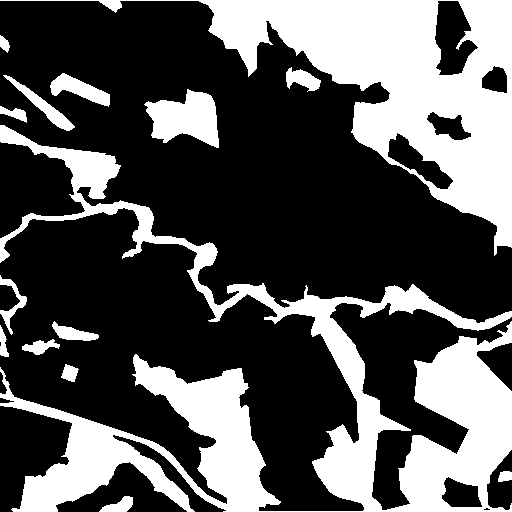

In [263]:
img = Image.open(get_mask_path(TILE_X, TILE_Y, mask_type="sugarcane-region"))
pixels = np.asarray(img)
print(np.shape(pixels))
im = Image.fromarray(np.uint8(pixels))
im